# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from numpy.random import seed
seed(1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from nn_models import lstm_prediction, dnn_prediction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from get_stock_data import get_stock_data
from get_macro_data import get_macro_data
from models import predict_regression
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from forecast import user_input
plt.style.use('seaborn-whitegrid')
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math

### Set options

In [2]:
models = ['RF', 'LGBM', 'L'] # available options are CBR (CatBoostRegressor), RF (RandomForestRegressor), SVM (SupportVectorRegressor), HGBR (HistGradientBoostingRegressor)
# GBR (GradientBoostingRegressor), ABR (AdaBoostRegressor), GPR (GaussianProcessRegressor), R (Ridge), LL (LassoLars), BR (BayesianRidge), XGB (XGBRegressor),
# KNN (KNeighborsRegressor), L (Lasso), MLP (MLPRegressor), LGBM (LGBMRegressor), ET (ExtraTreeRegressor) LR (LinearRegression), XGBRF (XGBRFRegressor),
# PR (PoissonRegressor), PAR (PassiveAggressiveRegressor), RNR (RadiusNeighborsRegressor)
training_data_split = 0.8 # as a decimal
shift = 3 # in days
new_stocks = [] # add strings of symbols of new stocks to include
start_date = "2016-01-01" # start date of stock data
end_date = "2021-12-29" # end date of stock data
cv_num = 3 # number of crossvalidations to do for hyperparameter tuning
trial_num = 100 # number of trials to find optimal hyperparameters

### Load financial data from yahoo finance API or local folder if available

In [3]:
ticker_hist_list, tickers = get_stock_data(new_stocks, start_date, end_date)

### Display all stock closing price plots

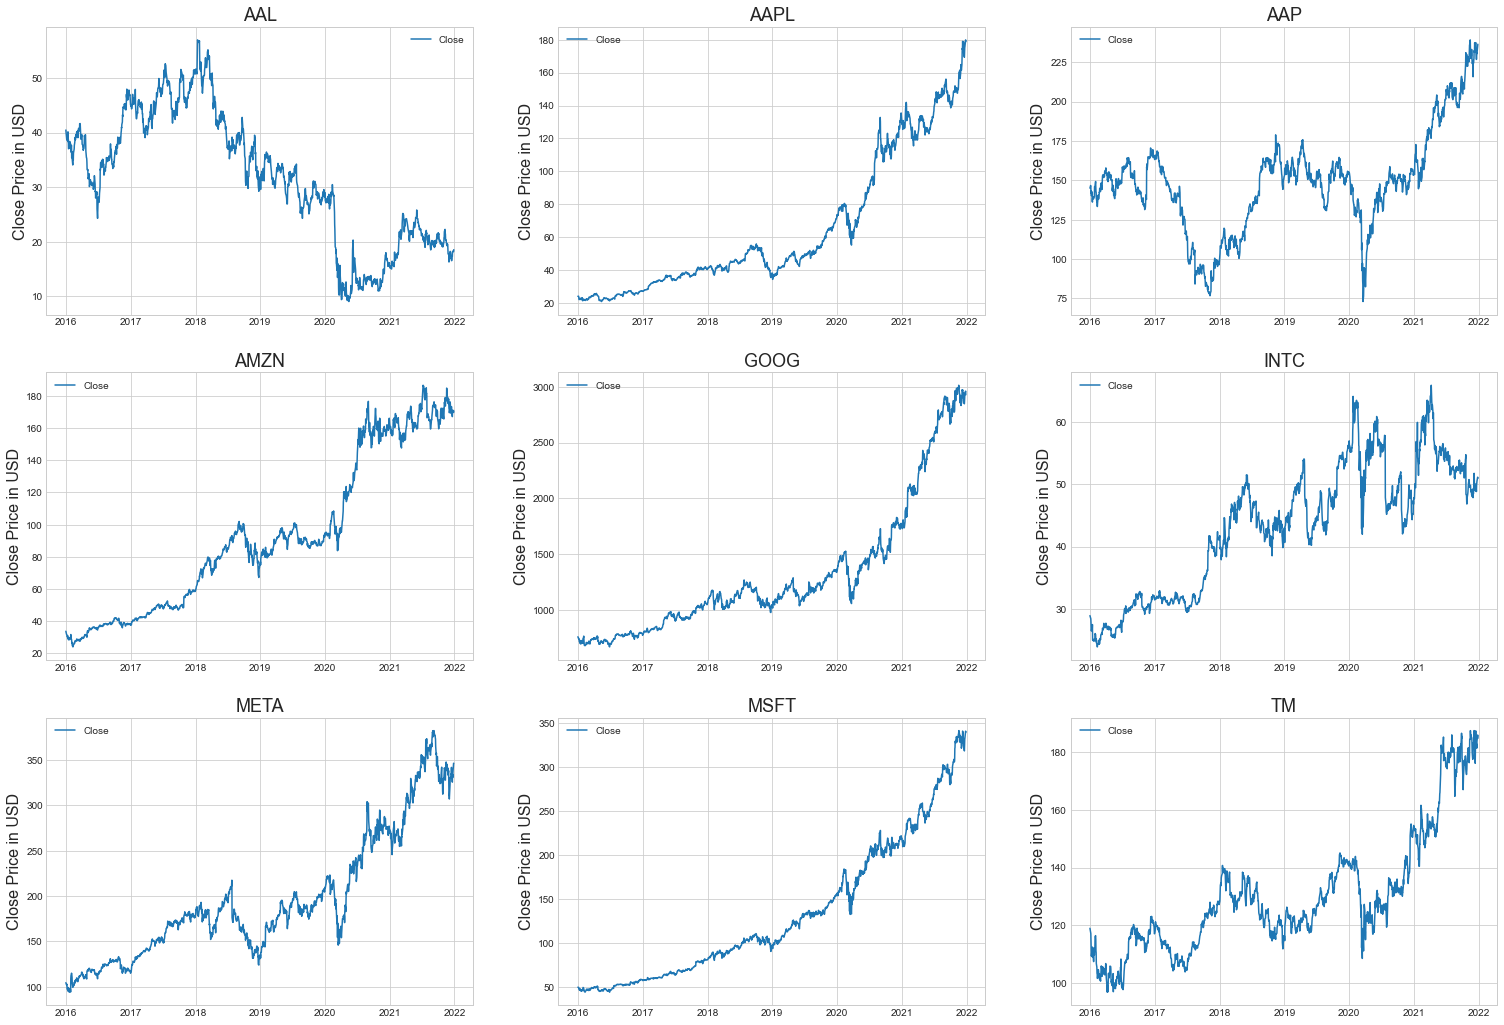

In [4]:
rows = int(math.ceil(len(tickers)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(26, 6*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(tickers[col], fontsize=18)
        ax[col].plot(ticker_hist_list[col]['Close'], label='Close')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + cols*row < len(tickers):
                ax[row, col].set_title(tickers[col + cols*row], fontsize=18)
                ax[row, col].plot(ticker_hist_list[col + cols*row]['Close'], label='Close')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Create one dataset with all stock data

In [5]:
stock_data = pd.concat(ticker_hist_list, axis=1)
col_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
stock_data.columns = [col_name + '.' + ticker for ticker in tickers for col_name in col_names]
stock_data.index.name = 'Date'
print(stock_data.shape)

(1509, 63)


In [7]:
stock_data.describe()

,Open.AAL,High.AAL,Low.AAL,Close.AAL,Volume.AAL,Dividends.AAL,Stock Splits.AAL,Open.AAPL,High.AAPL,Low.AAPL,...,Volume.MSFT,Dividends.MSFT,Stock Splits.MSFT,Open.TM,High.TM,Low.TM,Close.TM,Volume.TM,Dividends.TM,Stock Splits.TM
count,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03,1509.000000,1509.0,1509.000000,1509.000000,1509.000000,...,1.509000e+03,1509.000000,1509.0,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03,1509.000000,1509.0
mean,31.861866,32.366335,31.326608,31.823106,2.260404e+07,0.001127,0.0,64.860656,65.564819,64.195962,...,2.891730e+07,0.007329,0.0,130.089710,130.671150,129.407525,130.057355,2.392541e+05,0.002510,0.0
std,12.000448,12.067093,11.953753,12.018732,3.264196e+07,0.010558,0.0,41.397700,41.904273,40.900228,...,1.330391e+07,0.058424,0.0,20.858355,20.973081,20.743255,20.879439,1.508416e+05,0.069053,0.0
min,8.770000,9.190000,8.250000,9.040000,1.352400e+06,0.000000,0.0,20.899751,21.287557,20.776678,...,7.425600e+06,0.000000,0.0,96.758881,97.605991,96.335316,96.798271,4.840000e+04,0.000000,0.0
25%,21.430000,21.809999,21.020000,21.420000,5.685200e+06,0.000000,0.0,35.856740,36.226113,35.476306,...,2.062880e+07,0.000000,0.0,116.209999,117.089996,115.710733,116.398193,1.405000e+05,0.000000,0.0
50%,32.709352,33.131338,31.953317,32.538643,8.418300e+06,0.000000,0.0,46.447855,46.882947,46.127097,...,2.539070e+07,0.000000,0.0,125.320000,125.790001,124.720001,125.260002,1.947000e+05,0.000000,0.0
75%,41.272089,41.952318,40.730945,41.276730,2.898830e+07,0.000000,0.0,89.978680,91.060174,88.889780,...,3.312170e+07,0.000000,0.0,137.949997,138.679993,137.520004,138.149994,2.926000e+05,0.000000,0.0
max,57.300624,57.583278,56.335700,56.988731,4.286171e+08,0.100000,0.0,180.624141,181.631386,178.041235,...,1.335030e+08,0.620000,0.0,187.869995,188.949997,187.139999,187.440002,1.415500e+06,2.015000,0.0


### Load macro dataset

In [8]:
macro_data = pd.read_excel("Macrodata.xlsx", index_col=0)
macro_data = macro_data.fillna(0)
print(macro_data.shape)

(4531, 50)


In [9]:
macro_data.describe()

,10y_Inflation,5y_Inflation,10y_Treasury,2y_Treasury,5y_Treasury,TED_Spread,AAA_Bond_Yield,BAA_Bond_Yield,Unemployment,Unemployment_Black,...,New_Cons_Durable_Goods,Industrial_Production_Total,Nonfarm_Total,Debt_to_GDP,GDP,Gov_Expend_Total,Income_per_Capita,GDP_Per_Capita,Median_House_Price,Nonfarm_Payrolls_Total
count,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,...,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000
mean,0.020543,0.018615,0.028493,0.015907,0.021960,0.005027,-0.000073,-0.000073,0.004474,0.003026,...,0.004580,0.000581,0.000674,0.011822,0.010128,0.012493,0.009086,0.002947,0.010757,0.002051
std,0.004165,0.005719,0.011431,0.014634,0.012675,0.082806,0.013821,0.009844,0.130800,0.086401,...,0.079545,0.011393,0.008180,0.003015,0.013549,0.051954,0.014897,0.011787,0.024940,0.012439
min,0.000400,-0.022400,0.005200,0.000900,0.001900,-0.400000,-0.133500,-0.043600,-0.169200,-0.167200,...,-0.553100,-0.135900,-0.135700,0.006900,-0.093300,-0.143200,-0.055000,-0.089800,-0.062708,-0.107300
25%,0.017950,0.015700,0.019700,0.004100,0.012900,-0.043500,-0.007900,-0.006200,-0.018625,-0.029753,...,-0.015447,-0.001702,0.000674,0.009688,0.007630,0.002284,0.005315,0.001271,-0.005822,0.001915
50%,0.021400,0.018800,0.026500,0.009400,0.018300,0.004471,-0.001800,-0.001500,-0.005239,-0.003914,...,0.001700,0.001381,0.001286,0.010300,0.010611,0.010215,0.009408,0.003828,0.011262,0.003640
75%,0.023600,0.022600,0.038300,0.025100,0.029600,0.047600,0.007500,0.005800,0.007647,0.024631,...,0.020240,0.004384,0.001800,0.015934,0.014124,0.014423,0.013169,0.006288,0.025684,0.005300
max,0.027600,0.031700,0.052600,0.052900,0.052300,1.533300,0.180600,0.106400,2.215400,1.319000,...,1.031600,0.062000,0.033800,0.016900,0.085300,0.460400,0.117109,0.075000,0.077017,0.057900


### Adjust macrodata to stockdata size

In [10]:
macro_data = macro_data.drop(macro_data.index[:-stock_data.shape[0]-2])
macro_data = macro_data.drop(macro_data.index[-2:])
print(macro_data.shape)

(1509, 50)


In [11]:
# check if start and end date are the same
print(stock_data.head(2).index)
print(stock_data.tail(2).index)
print(macro_data.head(2).index)
print(macro_data.tail(2).index)

DatetimeIndex(['2015-12-31', '2016-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2015-12-31', '2016-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)


### Pull macroeconomic data from API

In [ ]:
get_macro_data()

### Add macroeconomic data to dataset

In [12]:
all_data = pd.concat([stock_data, macro_data], axis=1)
print(all_data.shape)

(1509, 113)


### Add lagged features to the dataset

In [13]:
for col in all_data:
    for i in range(1, shift):
        all_data[col + str(-i)] = all_data[col].shift(i)

In [14]:
# remove first i instances because of NaN from backward shifting
for i in range(1, shift):
    all_data.drop(index=all_data.index[0], axis=0, inplace=True)

### Split into train and test

In [15]:
colum_name = f'Close.{"AAP"}'

X = all_data.copy()
X = X.drop(columns=[colum_name])
y = all_data[colum_name].copy()

print(f'X shape: {X.shape} & y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)

print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} & y_test shape: {y_test.shape}')

X shape: (1507, 338) & y shape: (1507,)
X_train shape: (1205, 338) & X_test shape: (302, 338)
y_train shape: (1205,) & y_test shape: (302,)


### Apply MinMaxScaler to dataset

In [16]:
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.fit_transform(y_test.values.reshape(-1, 1))
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')

X_train shape: (1205, 338) & X_test shape: (302, 338)
X_train shape: (1205, 338) & X_test shape: (302, 338)


### Reshape input for LSTM model to match requirements

In [17]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f'X_train_nn shape: {X_train_nn.shape} & X_test_nn shape: {X_test_nn.shape}')
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
print(f'y_train_nn shape: {y_train.shape} & y_test_nn shape: {y_test.shape}')

X_train_nn shape: (1205, 338, 1) & X_test_nn shape: (302, 338, 1)
y_train_nn shape: (1205, 1) & y_test_nn shape: (302, 1)


### Fit LSTM model

In [18]:
history_lstm, test_predict_lstm = lstm_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

In [19]:
print(history_lstm.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history_lstm.epoch, history_lstm.history['loss'], label = "mse")
plt.plot(history_lstm.epoch, history_lstm.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Calculate RMSE and MAE

In [20]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict_lstm))}')
print(f'MSE: {mean_squared_error(y_test, test_predict_lstm)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict_lstm)}')

### Plot prediction vs actual close price

In [21]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price with LSTM - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict_lstm, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Inverse predictions (if needed)

In [22]:
# y_test = scaler_y.inverse_transform(y_test)
# test_predict_lstm = scaler_y.inverse_transform(test_predict_lstm)

### Fit LSTM model

In [ ]:
history_dnn, test_predict_dnn = dnn_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

In [ ]:
print(history_dnn.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history_dnn.epoch, history_dnn.history['loss'], label = "mse")
plt.plot(history_dnn.epoch, history_dnn.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Calculate RMSE and MAE

In [ ]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict_dnn))}')
print(f'MSE: {mean_squared_error(y_test, test_predict_dnn)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict_dnn)}')

### Plot prediction vs actual close price

In [ ]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price with DNN- {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict_dnn, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Preparation for non-NN Models

In [23]:
X = stock_data.drop([f'Close.{"AAP"}'], axis=1)
y = stock_data[f'Close.{"AAP"}']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
print(f'Training sample size: {X_train.shape[0]} and testing sample size: {X_test.shape[0]}.')

Training sample size: 1207 and testing sample size: 302.


### Apply MinMaxScaler to dataset

In [24]:
scaler_x2 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
X_train = scaler_x2.fit_transform(X_train)
X_test = scaler_x2.fit_transform(X_test)
y_train = scaler_y2.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y2.fit_transform(y_test.values.reshape(-1, 1))

### Prediction with Logistic Regression

In [25]:
y_pred, studies = predict_regression(models, X_train, y_train, X_test, cv_num, trial_num)

{'n_estimators': 100, 'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 'auto'}
done with RF
{'n_estimators': 45, 'max_depth': 20, 'num_leaves': 15}
done with LGBM
{'alpha': 7.006883779630582e-06, 'fit_intercept': True}
done with L


In [26]:
x = PrettyTable()
x.field_names = ["Model", "R2 Score", 'RMSE', 'MAE', 'Max Error']

for key, value in y_pred.items():
    x.add_row([key, format(r2_score(y_test, value), '.4f'), format(math.sqrt(mean_squared_error(y_test, value)), '.4f'), \
               format(mean_absolute_error(y_test, value), '.4f'), format(max_error(y_test, value), '.4f')])

print(x)

+-------+----------+--------+--------+-----------+
| Model | R2 Score |  RMSE  |  MAE   | Max Error |
+-------+----------+--------+--------+-----------+
|   RF  |  0.9940  | 0.0220 | 0.0170 |   0.0906  |
|  LGBM |  0.9937  | 0.0224 | 0.0174 |   0.0764  |
|   L   |  0.9970  | 0.0154 | 0.0126 |   0.0418  |
+-------+----------+--------+--------+-----------+


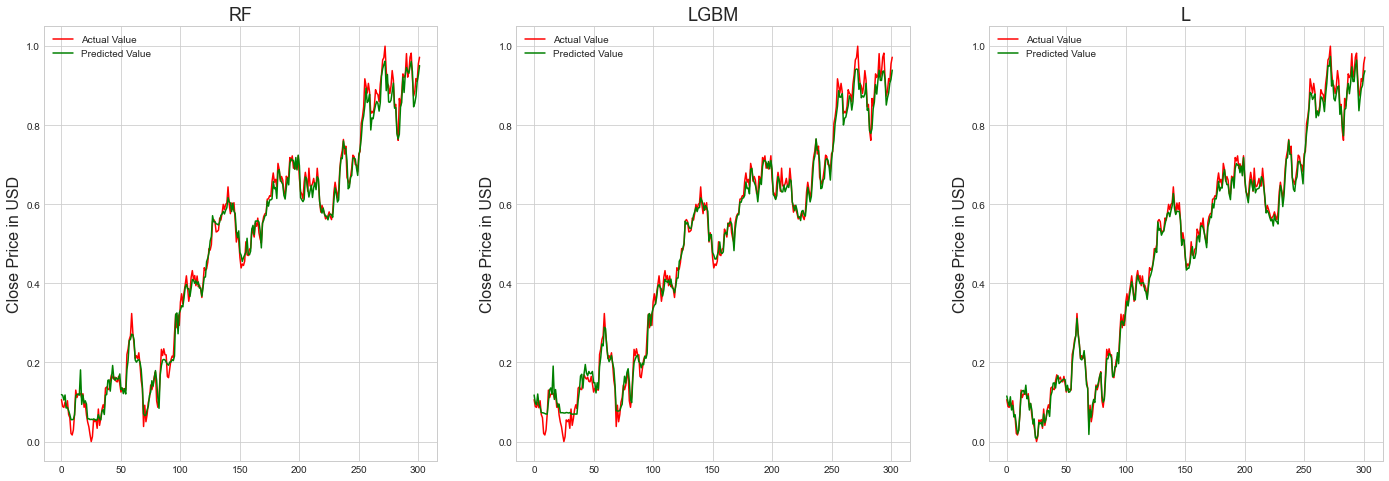

In [27]:
rows = int(math.ceil(len(models)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(24, 8*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(models[col], fontsize=18)
        ax[col].plot(y_test, color='red', label='Actual Value')
        ax[col].plot(y_pred[models[col]], color='green', label='Predicted Value')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + cols*row < len(models):
                ax[row, col].set_title(models[col + cols*row], fontsize=18)
                ax[row, col].plot(y_test, color='red', label='Actual Value')
                ax[row, col].plot(y_pred[models[col + cols*row]], color='green', label='Predicted Value')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Function to predict user selected stock performance

In [28]:
# user_input()